# Feature importance check

In [23]:

from src.util import read_results, train_test_validate_split, ExplodeColumns, model_operators, eval_result
import numpy as np 
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
# plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
result_df = read_results(from_parquet=True)
result_df.columns
result_df = result_df.drop(columns=['features'])

In [25]:
list_features = [x for x in result_df.columns if result_df[x].apply(lambda x: isinstance(x, (list, np.ndarray))).any()]
result_df = ExplodeColumns(columns=list_features, max_len=5).transform(result_df)

Expanding columns: 100%|██████████| 6/6 [03:32<00:00, 35.33s/it]


In [26]:
categorical_columns = result_df.select_dtypes(include=['object']).columns.tolist()
print(f"Dropping {categorical_columns}")
for col in categorical_columns:
    result_df[col] = result_df[col].astype('category')

Dropping ['dataset', 'operator', 'join', 'compute_unit', 'source_file', 'dataset_type', 'compute_type', 'parallelism', 'gpu__architecture']


In [27]:
target_cols = ['speedup', 'times_mean', 'label', 'time_saved', 'materialized_times_mean']

def split_data(df, target_cols):
    X = df.drop(columns=target_cols)
    y = df[target_cols]
    return X, y

train, test, validate = train_test_validate_split(result_df)
X_train, y_train = split_data(train, target_cols)
X_test, y_test = split_data(test, target_cols)
X_validate, y_validate = split_data(validate, target_cols)


train set:
	Records: 210953
	Positive (speedup > 1 with factorizing)/Negative: 39406/171547 = 0.23 s
	Dataset types: ['synthetic', 'hamlet']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['CPU 32c', '1080', 'CPU 16c', 'CPU 08c', 'v100', '2080', 'a40', 'p100']
Categories (8, object): ['1080', '2080', 'CPU 08c', 'CPU 16c', 'CPU 32c', 'a40', 'p100', 'v100']
test set:
	Records: 90409
	Positive (speedup > 1 with factorizing)/Negative: 17014/73395 = 0.23 s
	Dataset types: ['synthetic', 'hamlet']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['2080', '1080', 'CPU 16c', 'a40', 'v100', 'CPU 08c', 'CPU 32c', 'p100']
Categories (8, object): ['1080', '2080', 'CPU 08c', 'CPU 16c', 'CPU 32c', 'a40', 'p100', 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic', 'hamlet', 'tpc_ai']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['p100',

In [28]:
cols = result_df.head(1).T

In [29]:
from sklearn.metrics import mean_squared_error
import seaborn as sns


def plot_boundary(y_true, y_pred, lower=-1.0, upper=1.0, step=0.1, target_col=None, full_dataset=None, ax=None):
    # Create a list to store the results
    results = []

    # Loop over the range of boundaries
    x = np.arange(lower, upper, step)
    for boundary in x:
        result = eval_result(y_true, y_pred=y_pred > boundary, full_dataset=full_dataset, target_col=target_col)
        results.append({"boundary": boundary, **result[2]})

    dd = pd.DataFrame(results)
    ax = sns.scatterplot(data=dd, x="boundary", y="y_pred_time_saved", label="time_saved", ax=ax)
    sns.scatterplot(data=dd, x="boundary", y="y_pred_speedup_real", ax=ax.twinx(), label="speedup", color="orange")
    ax.grid()
    ax.legend(loc="lower right")
    ax.set_title(f"Boundary vs. Time saved {target_col}")
    return ax


def train_and_eval(name, X_train, y_train, X_test, y_test, X_validate, y_validate, target_col, only_model=False, estimator_kwargs={}):
    model_operators_mask_test = X_test["operator"].isin(model_operators)
    X_test = X_test.loc[model_operators_mask_test]
    y_test = y_test.loc[model_operators_mask_test]

    model_operators_mask_validate = X_validate["operator"].isin(model_operators)
    X_validate = X_validate[model_operators_mask_validate]
    y_validate = y_validate.loc[model_operators_mask_validate]
    df_filtered = result_df[result_df["operator"].isin(model_operators)]
    if only_model:
        # Filter the datasets based on the condition
        model_operators_mask_train = X_train["operator"].isin(model_operators)
        X_train = X_train[model_operators_mask_train]
        y_train = y_train.loc[model_operators_mask_train]
    else:
        df_filtered = result_df

    clf = xgboost.XGBRegressor(enable_categorical=True, **estimator_kwargs)
    clf.fit(X_train, y_train[target_col])
    display(pd.DataFrame(zip(X_train.columns, clf.feature_importances_)).sort_values(1, ascending=False).head(10))

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for X, y, dataset_name, ax in zip(
        [X_train, X_test, X_validate], [y_train, y_test, y_validate], ["train", "test", "validate"], axs
    ):
        plt.sca(ax)
        y_true = y[target_col]
        y_pred = clf.predict(X)
        print(name, dataset_name, mean_squared_error(y_true, y_pred))

        if isinstance(target_col, list):
            print("Assuming target cols are materialized_times_mean and times_mean")
            pred = pd.DataFrame(y_pred, index=y_true.index)
            pred.columns = y_true.columns
            y_pred = pred["materialized_times_mean"] - pred["times_mean"]
            y_true = y_true["materialized_times_mean"] - y_true["times_mean"]
            eval_target_col = 'time_saved'
        else:
            eval_target_col = target_col

        lower, upper = (0.8, 2.0) if target_col == "speedup" else (-1.0, 1.0)
        ax = plot_boundary(y_true, y_pred, lower,upper, target_col=eval_target_col, full_dataset=df_filtered.loc[y_true.index],ax=ax)
        xgb_results[(name, dataset_name)] = eval_result(
            y_true,
            y_pred,
            full_dataset=df_filtered.loc[y_true.index],
            model_name=f"{name}: {dataset_name}",
            target_col=eval_target_col,
            plot=True,
        )[0]
    return clf

[(['times_mean', 'materialized_times_mean'], True),
 (['times_mean', 'materialized_times_mean'], False),
 ('speedup', True),
 ('speedup', False),
 ('time_saved', False),
 ('time_saved', True)]

,0,1
0,operator,0.327522
11,mem_fac_read,0.182063
1,num_cores,0.111169
9,mem_mat_read,0.046223
3,cardinality_T,0.041379
21,comp_scalar_dense,0.038173
24,comp_matrix_dense,0.037985
14,comp_lmm_mat,0.027783
17,comp_lmm_fac,0.022608
29,mem_read_rowsum,0.020875


XGB.1 train 0.07283164771305527
Assuming target cols are materialized_times_mean and times_mean
XGB.1 test 0.21746787371356915
Assuming target cols are materialized_times_mean and times_mean
XGB.1 validate 18.203153478242683
Assuming target cols are materialized_times_mean and times_mean


,0,1
0,operator,0.256719
11,mem_fac_read,0.149788
1,num_cores,0.120205
21,comp_scalar_dense,0.102622
10,mem_mat_write,0.063182
9,mem_mat_read,0.060028
3,cardinality_T,0.033981
24,comp_matrix_dense,0.031450
14,comp_lmm_mat,0.027981
17,comp_lmm_fac,0.023187


XGB.2 train 0.020861893163069103
Assuming target cols are materialized_times_mean and times_mean
XGB.2 test 0.23588486360099392
Assuming target cols are materialized_times_mean and times_mean
XGB.2 validate 18.98914797232736
Assuming target cols are materialized_times_mean and times_mean


,0,1
37,comp_mat,0.176501
1,num_cores,0.063061
27,mem_read_matrix_dense,0.059615
39,comp_ratio,0.056464
44,nnz_T,0.055651
29,mem_read_rowsum,0.051842
0,operator,0.048634
10,mem_mat_write,0.042979
47,c_T,0.041761
45,nnz_S_sum,0.037098


XGB.3 train 0.005449459663362833
XGB.3 test 0.021508409858495038
XGB.3 validate 2.3970107626131036


,0,1
2,selectivity,0.296094
55,gpu_cache_size_l1,0.181915
43,FR,0.121042
68,r_S_2,0.117061
47,c_T,0.111066
0,operator,0.043501
52,gpu__architecture,0.040697
1,num_cores,0.028871
72,c_S_1,0.016247
44,nnz_T,0.014800


XGB.4 train 3.5065448438901337
XGB.4 test 0.0479305520927044
XGB.4 validate 12.665478318962426


,0,1
0,operator,0.324433
1,num_cores,0.121896
67,r_S_1,0.115666
45,nnz_S_sum,0.080912
11,mem_fac_read,0.064890
6,complexity_ratio,0.057413
3,cardinality_T,0.030881
5,join,0.030356
39,comp_ratio,0.023935
10,mem_mat_write,0.019308


XGB.5 train 0.04045808984305822
XGB.5 test 0.4544369948788237
XGB.5 validate 10.386284902747764


,0,1
0,operator,0.242031
1,num_cores,0.138371
67,r_S_1,0.115246
45,nnz_S_sum,0.099010
6,complexity_ratio,0.071990
11,mem_fac_read,0.069451
3,cardinality_T,0.030887
5,join,0.030151
39,comp_ratio,0.024556
9,mem_mat_read,0.022700


/tmp/ipykernel_47250/3150453588.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(15, 4))


XGB.6 train 0.1498843370161799
XGB.6 test 0.4332336883598005
XGB.6 validate 9.7781937627873


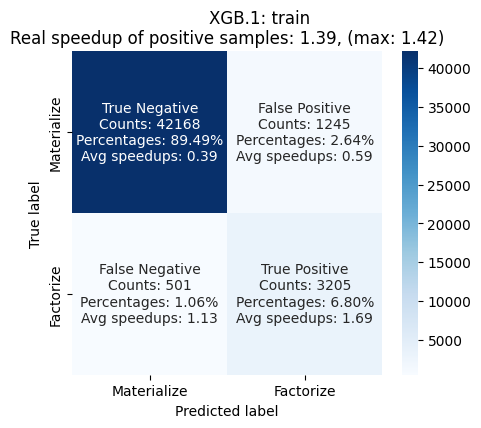

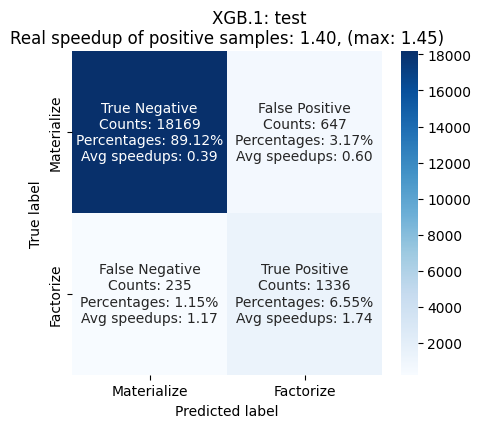

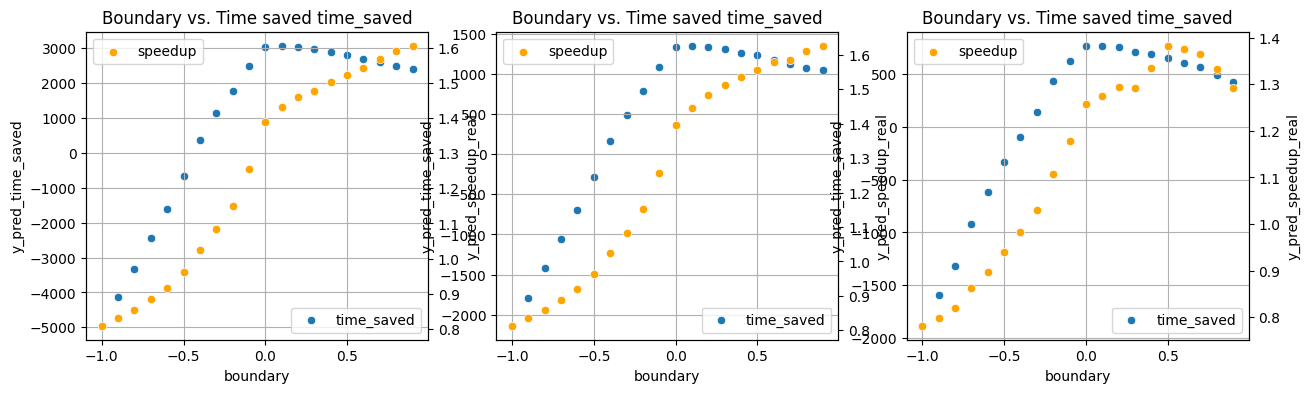

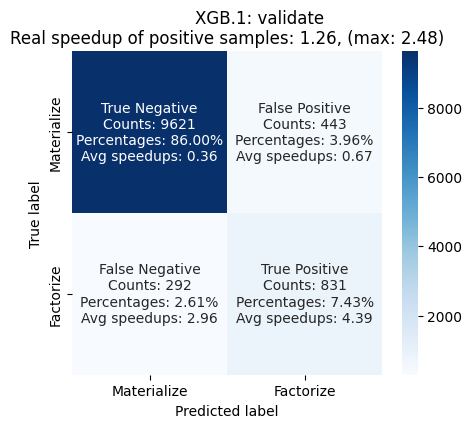

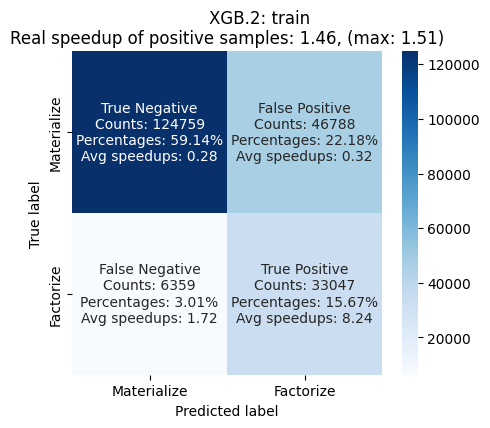

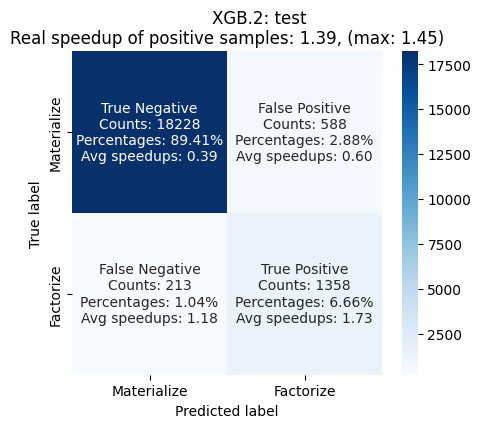

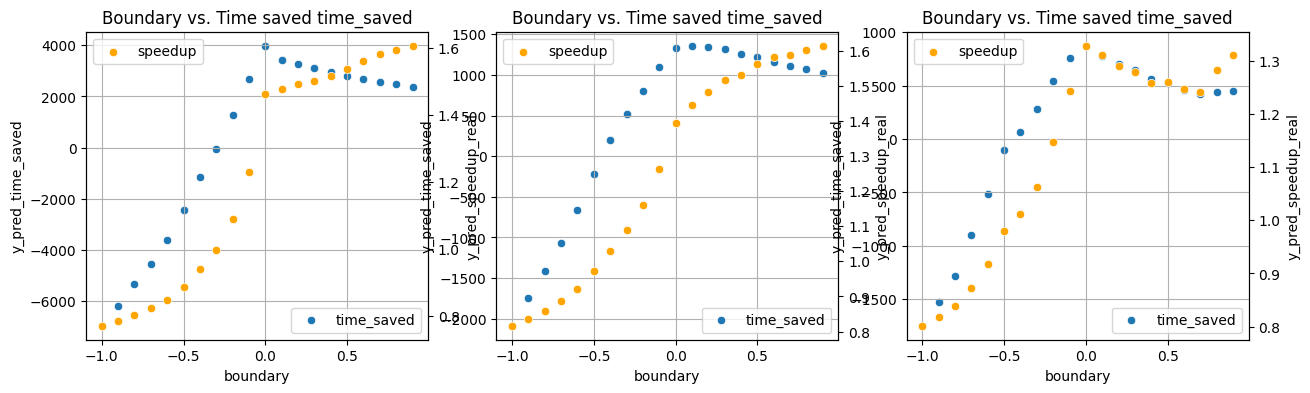

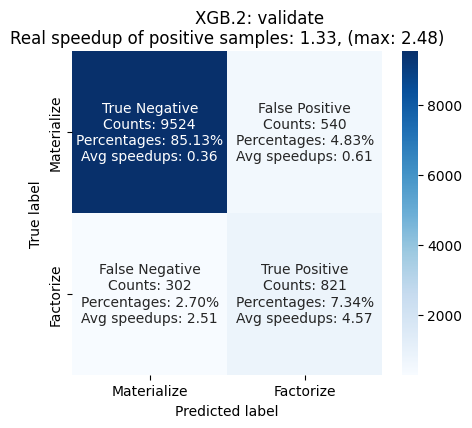

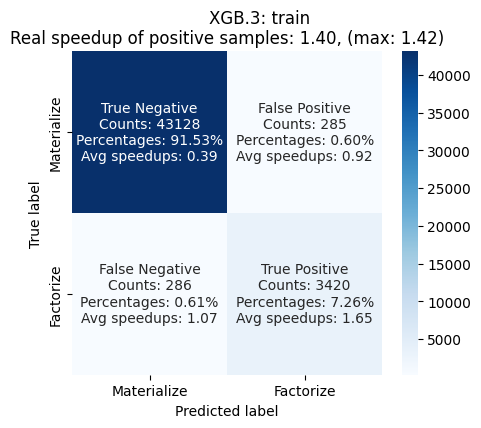

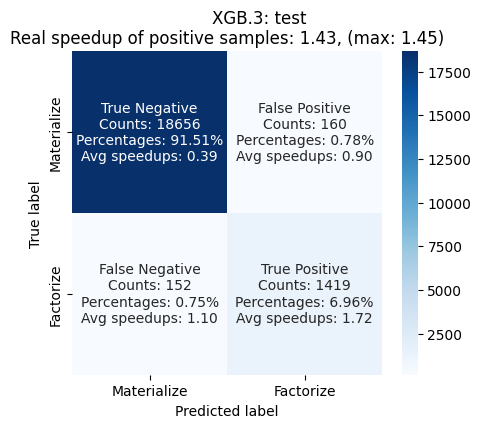

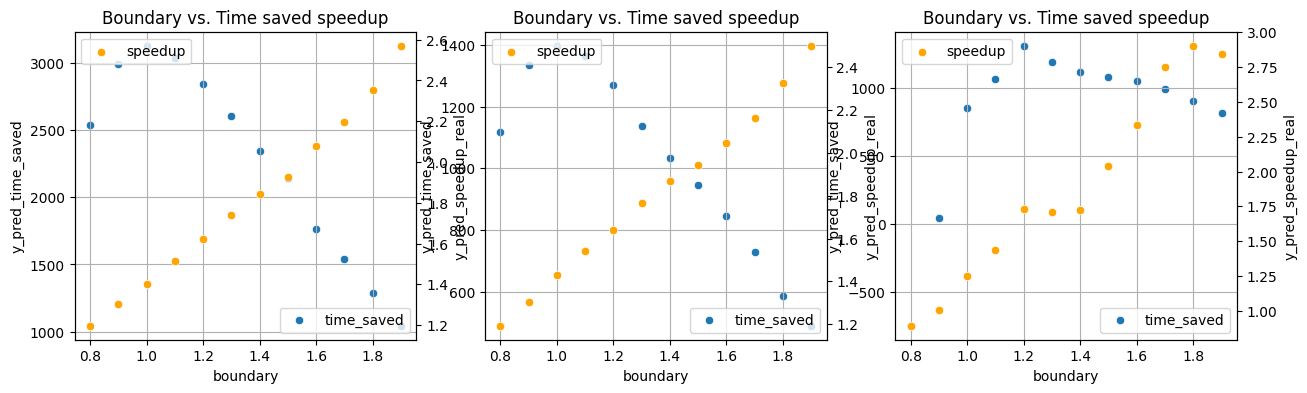

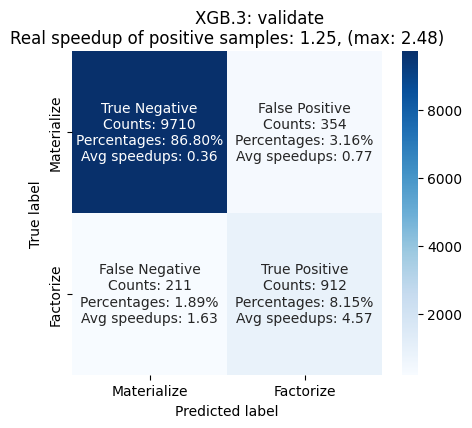

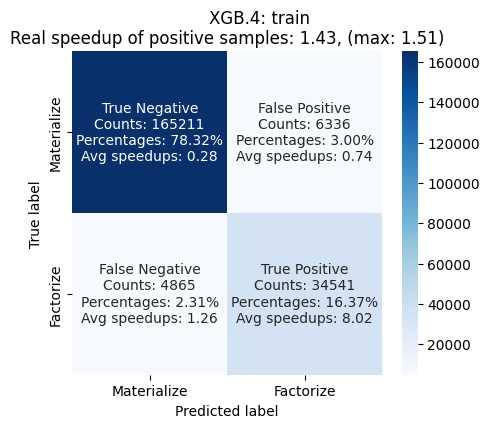

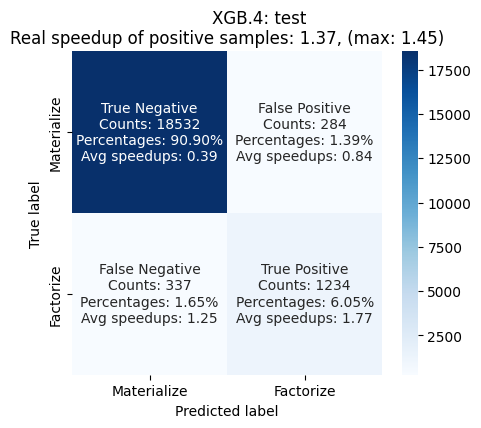

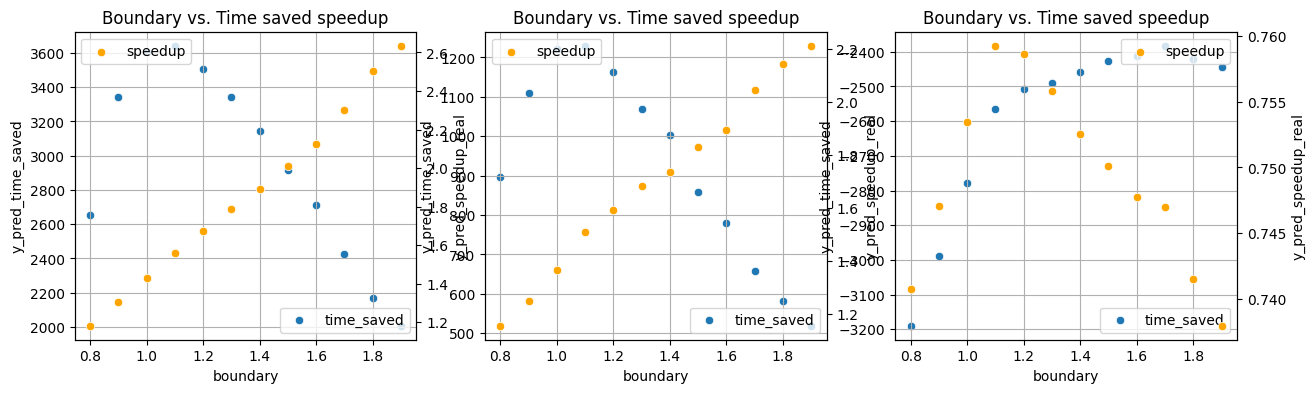

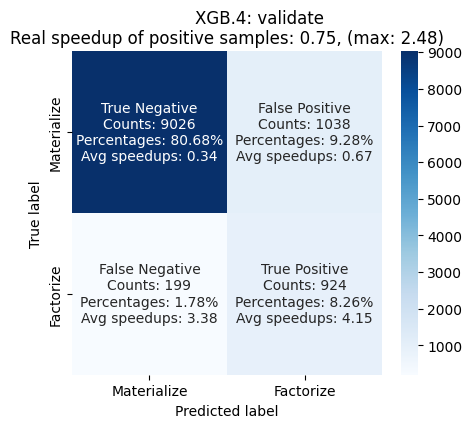

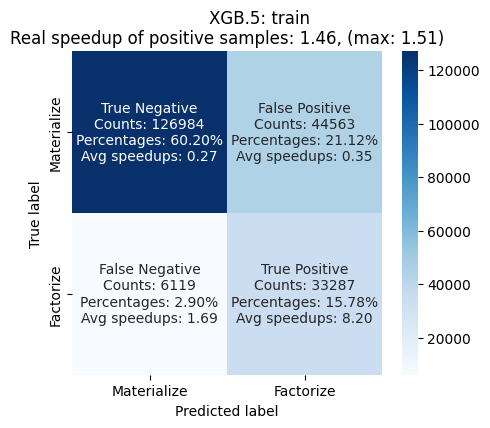

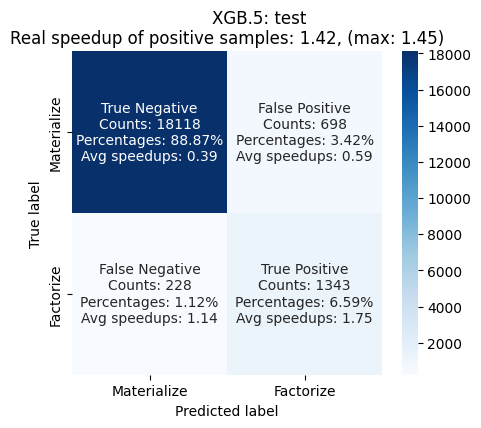

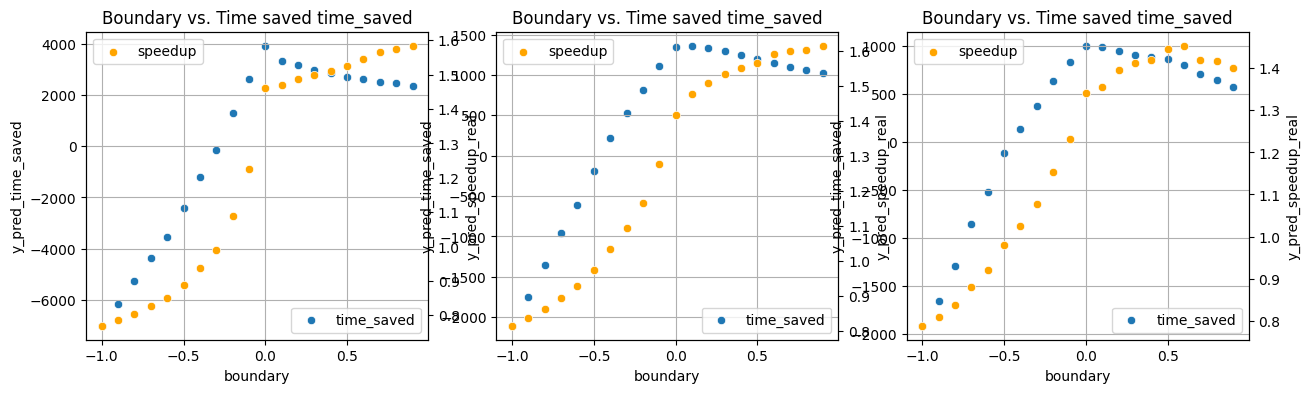

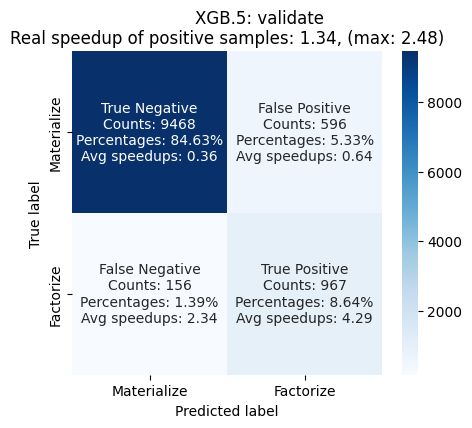

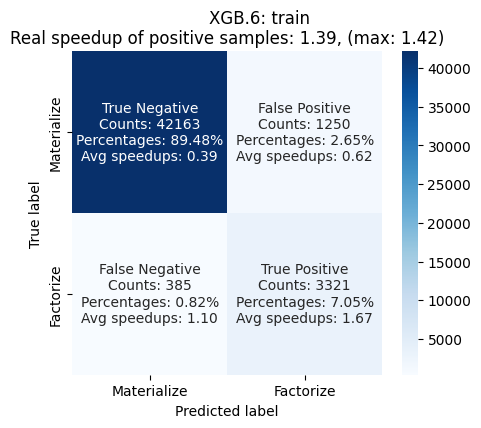

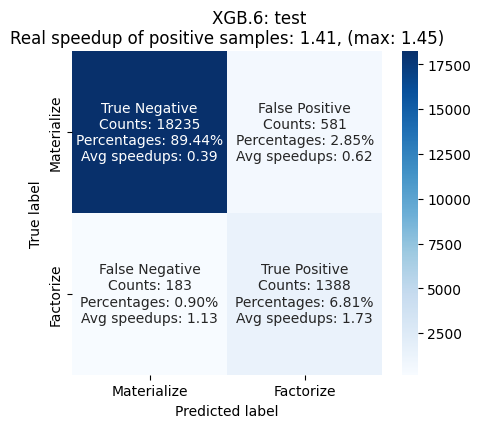

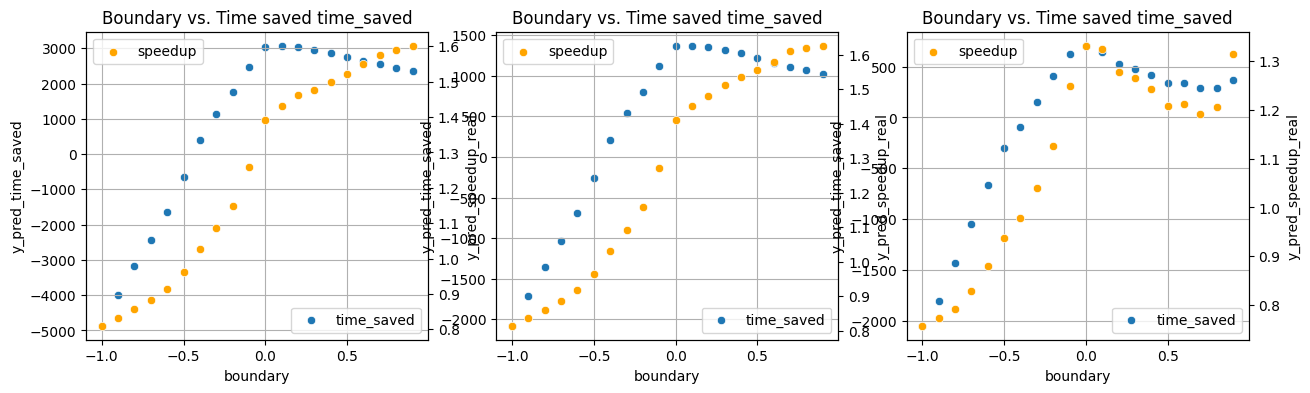

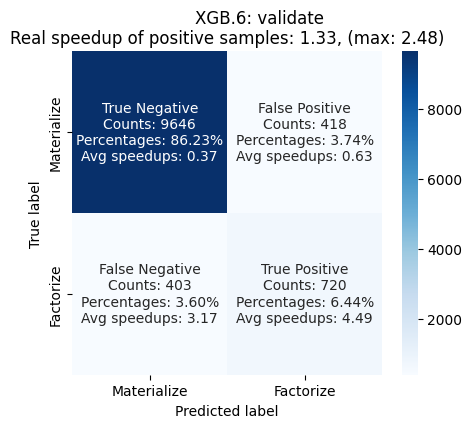

In [30]:
l= list(zip(["speedup", "time_saved", ["times_mean", "materialized_times_mean"]]*2, [True, False]*3))
l.sort(key=lambda x: str(x[0]))
display(l)
xgb_results = {}
xgb_estimators = {}
for i, (target_col, only_model) in enumerate(l):
    xgb_estimators[f"XGB.{i+1}"] = (target_col, only_model), train_and_eval(f"XGB.{i+1}",X_train, y_train, X_test, y_test, X_validate, y_validate, target_col, only_model=only_model)


In [31]:
import pickle
with open("trained_models/xgb3.pkl", "wb") as f:
    pickle.dump(xgb_estimators["XGB.3"][1], f)

In [32]:
xgb_results

{('XGB.1', 'train'): {'r2': 0.9880922678308557,
  'mean_squared_error': 0.1436586379860065,
  'accuracy': 0.9629448842292918,
  'precision': 0.7202247191011236,
  'recall': 0.8648138154344307,
  'f1': 0.7859244727807749,
  'speedup': {'y_true_mat_time': 10884.924061771591,
   'y_true_fact_time': 7684.917906483865,
   'y_true_best_time': 7684.917906483865,
   'y_true_time_saved': 3200.006155287726,
   'y_true_speedup_avg': 1.6098942396715852,
   'y_true_speedup_real': 1.4164008248660456,
   'y_pred_mat_time': 10912.745973848405,
   'y_pred_fact_time': 7865.16059838072,
   'y_pred_best_time': 7758.068644720802,
   'y_pred_time_saved': 3047.5853754676846,
   'y_pred_speedup_avg': 1.3803141445020437,
   'y_pred_speedup_real': 1.3874791032360003,
   'TP': (3205, 1.6853877964835433),
   'FP': (1245, 0.5949638998428416),
   'TN': (42168, 0.39018945497527724),
   'FN': (501, 1.126946436114049)}},
 ('XGB.1', 'test'): {'r2': 0.9642850359073586,
  'mean_squared_error': 0.4301296850897279,
  'accu

In [33]:
resdf = pd.DataFrame(xgb_results.values())
resdf['Model'] = [x[0] for x in xgb_results.keys()]
resdf['dataset'] = [x[1] for x in xgb_results.keys()]
resdf['target'] = np.array([[str(x[0])] * 3 for x in l]).flatten()
resdf['target'] = resdf['target'].replace({"['times_mean', 'materialized_times_mean']": "time_saved"})
resdf['pruned'] = np.array([[x[1]] * 3 for x in l]).flatten()
resdf = resdf.merge(pd.json_normalize(resdf.speedup), left_index=True, right_index=True)
resdf['fraction_of_optimal_time_saved'] = resdf.y_pred_time_saved / resdf.y_true_time_saved
resdf

,r2,mean_squared_error,accuracy,precision,recall,f1,speedup,Model,dataset,target,...,y_pred_fact_time,y_pred_best_time,y_pred_time_saved,y_pred_speedup_avg,y_pred_speedup_real,TP,FP,TN,FN,fraction_of_optimal_time_saved
0,0.988092,0.143659,0.962945,0.720225,0.864814,0.785924,"{'y_true_mat_time': 10884.924061771591, 'y_tru...",XGB.1,train,time_saved,...,7865.160598,7758.068645,3047.585375,1.380314,1.387479,"(3205, 1.6853877964835433)","(1245, 0.5949638998428416)","(42168, 0.39018945497527724)","(501, 1.126946436114049)",0.952369
1,0.964285,0.430130,0.956737,0.673727,0.850414,0.751829,"{'y_true_mat_time': 4719.159600592462, 'y_true...",XGB.1,test,time_saved,...,3360.346654,3293.050809,1335.596718,1.370151,1.397458,"(1336, 1.7445684810827409)","(647, 0.5970113774016801)","(18169, 0.38896068473642403)","(235, 1.166486545205542)",0.916029
2,0.646418,7.113001,0.934299,0.652276,0.739982,0.693367,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.1,validate,time_saved,...,2998.918397,2614.823004,770.245757,3.096741,1.256841,"(831, 4.389143749277247)","(443, 0.6723930790773982)","(9621, 0.3629732540281537)","(292, 2.9574644752842705)",0.461931
3,0.986716,0.041101,0.748062,0.413941,0.838629,0.554289,"{'y_true_mat_time': 12576.204111394778, 'y_tru...",XGB.2,train,time_saved,...,8609.086937,8422.659972,3983.709650,3.598293,1.462733,"(33047, 8.24268619642998)","(46788, 0.3178945398741775)","(124759, 0.2839359539813872)","(6359, 1.7190248881872863)",0.935095
4,0.961225,0.466984,0.960710,0.697842,0.864418,0.772249,"{'y_true_mat_time': 4719.159600592462, 'y_true...",XGB.2,test,time_saved,...,3395.181112,3324.337679,1334.859483,1.390087,1.393163,"(1358, 1.7332501607961819)","(588, 0.5975425370494101)","(18228, 0.3896169645803118)","(213, 1.1789394858621074)",0.915524
5,0.592363,8.200425,0.924734,0.603233,0.731077,0.661031,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.2,validate,time_saved,...,2655.441545,2264.276243,873.329747,2.998514,1.328883,"(821, 4.571406822482169)","(540, 0.6071338903504786)","(9524, 0.36352199813596137)","(302, 2.509381063491848)",0.523752
6,0.973197,0.005449,0.987882,0.923077,0.922828,0.922952,"{'y_true_mat_time': 10884.924061771591, 'y_tru...",XGB.3,train,speedup,...,7753.607862,7717.600428,3128.985078,1.598471,1.403552,"(3420, 1.6546969651013193)","(285, 0.9237553994877299)","(43128, 0.3925748632871412)","(286, 1.0741413691481903)",0.977806
7,0.901534,0.021508,0.984696,0.898670,0.903246,0.900952,"{'y_true_mat_time': 4719.159600592462, 'y_true...",XGB.3,test,speedup,...,3263.794159,3233.993233,1397.199173,1.635604,1.428090,"(1419, 1.7182055456895866)","(160, 0.9030287932138699)","(18656, 0.39176717598846256)","(152, 1.096935259975794)",0.958280
8,0.276108,2.397011,0.949495,0.720379,0.812110,0.763499,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.3,validate,speedup,...,3379.418965,2695.544660,848.548721,3.508378,1.251093,"(912, 4.569648784554498)","(354, 0.7742568459785595)","(9710, 0.362095662982466)","(211, 1.6276700991407456)",0.508891
9,0.986691,3.506545,0.946903,0.844998,0.876542,0.860481,"{'y_true_mat_time': 12576.204111394778, 'y_tru...",XGB.4,train,speedup,...,8367.042236,7995.389184,3606.154178,6.895375,1.430995,"(34541, 8.024851707041437)","(6336, 0.7379827430594729)","(165211, 0.2761399468217738)","(4865, 1.262266636071165)",0.846471


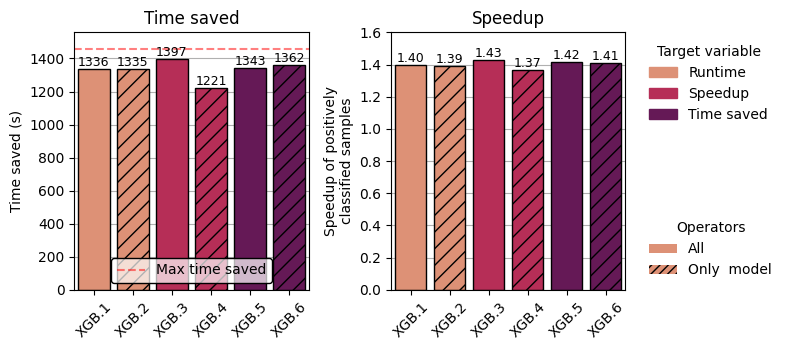

In [39]:
import matplotlib

pal = sns.color_palette("rocket_r", 3)[:3]
colors = [pal[0], pal[0], pal[1], pal[1], pal[2], pal[2]]
colors = [sns.set_hls_values(c, s=0.6) for c in colors]
hatches = ["", "//", "", "//", "", "//"]	

f, axs = plt.subplots(1, 2, figsize=(8, 0.45*8))
labels = ["Time saved (s)", "Speedup of positively\nclassified samples", "Fraction of best time saved"]
titles = ["Time saved", "Speedup", "Performance"]
max_time_saved = resdf[resdf.dataset=='test'].y_true_time_saved.max()

for ax, var, label, title in zip(axs, ["y_pred_time_saved", "y_pred_speedup_real", "fraction_of_optimal_time_saved"][:2], labels[:2], titles[:2]):
    sns.barplot(
        data=resdf[(resdf.dataset == "test")],
        x="Model",
        y=var,
        ax=ax,
        saturation=0.6,
        edgecolor="black",
        linewidth=1,
        palette=sns.color_palette("rocket_r"),
        # hue="target",
        # style='target'
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(axis="y")
    ax.set_axisbelow(True)
    ax.set_ylabel(label)
    ax.set_xlabel("Target variable")
    ax.set_xlabel(None)
    ax.set_title(title)
    # ax.set_xticklabels(["XGB.1\nSpeedup", "XGB.2\nTime saved", "XGB.3 Time saved\n(separate F/M)"], rotation=45)
    fmt = ".2f"
    if var == "fraction_of_optimal_time_saved":
        # ax.set_ylim(0, 1)
        ...
    elif var == "y_pred_speedup_real":
        ax.set_ylim(top=1.6)
        ...
    elif var == "y_pred_time_saved":
        # ax.set_ylim(0, 1400)
        # ax.set_ylim(1000, max_time_saved+100)
        fmt = ".0f"
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max time saved", alpha=0.5)
        legend = ax.legend(loc='lower center', framealpha=0.8, fancybox=True)
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_facecolor((1, 1, 1, 0.7))
        ax.set_ylim(top=max_time_saved+100)
        
    for i, bar in enumerate(ax.patches):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), format(bar.get_height(), fmt), 
                ha='center', va='bottom', fontsize=9)
        bar.set_facecolor(colors[i])
        bar.set_hatch(hatches[i])

cs = {'Runtime':colors[0], 'Speedup':colors[2], 'Time saved':colors[4]}         
labels = list(cs.keys())
handles = [plt.Rectangle((0,0),1,1, color=cs[label]) for label in labels]  
l1 = axs[1].legend(handles, labels, loc='upper left', title="Target variable", bbox_to_anchor=(1.05, 1), frameon=False)
hatches = {'All': None, 'Only  model': r'////'}
handles = [matplotlib.patches.Patch(facecolor=colors[0], hatch=hatches[label]) for label in hatches.keys()]
l2 = axs[1].legend(handles, hatches.keys(), loc='lower left', title="Operators" , bbox_to_anchor=(1.05, 0), frameon=False)
axs[1].add_artist(l1)
# axs[1].add_artist(l2)
f.tight_layout()
f.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/xgb-models-compare.pdf", bbox_inches='tight')

In [47]:
y_validate

,speedup,times_mean,label,time_saved,materialized_times_mean
117,0.480518,1.331066,False,-0.691465,0.639601
125,0.311939,0.085030,False,-0.058506,0.026524
133,0.684526,0.461269,False,-0.145518,0.315751
141,0.589948,0.401411,False,-0.164600,0.236812
262,0.220729,2.855978,False,-2.225580,0.630398
...,...,...,...,...,...
347740,1.127311,2.117749,True,0.269614,2.387363
347741,1.698412,1.838746,True,1.284202,3.122949
347742,1.253318,2.465284,True,0.624502,3.089785
347743,1.342074,3.367059,True,1.151782,4.518841


In [57]:
y_true = y_validate.speedup
y_pred = xgb_estimators["XGB.3"][1].predict(X_validate)
pd.DataFrame({"xgb_y_true_speedup": y_true > 1.0, "xgb_y_pred_speedup": y_pred > 1.0}).to_csv("evaluation/predictions/xgb_label.csv")

# Hyperparams

In [35]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer


# def time_saved(y_true, y_pred):
#     tot_time_pred = y_true[y_pred > 0].sum()
#     return tot_time_pred
       

# # Define the hyperparameter grid
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.5, 0.7, 1], 
#     "lambda": [0.5, 1, 2],
#     "alpha": [0.5, 1, 2],
# }

# # Create the XGBoost model object
# xgb_model = xgboost.XGBRegressor(enable_categorical=True)

# # Create the GridSearchCV object
# grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring={"time_saved": make_scorer(time_saved, greater_is_better=True),
#                                                                  "mse": "neg_mean_squared_error"}, refit="time_saved", verbose=3)

# target_col = 'time_saved'
# loc = X_train["operator"].isin(model_operators)
# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train.loc[loc], y_train.loc[loc][target_col])

# # Print the best set of hyperparameters and the corresponding score
# print("Best set of hyperparameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

In [36]:
# train_and_eval(X_train, y_train, X_test, y_test, X_validate, y_validate, 'time_saved', only_model=True, estimator_kwargs={'alpha': 0.5, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7})

In [37]:
# train_and_eval(X_train, y_train, X_test, y_test, X_validate, y_validate, ['materialized_times_mean', 'times_mean'], only_model=True, estimator_kwargs={'alpha': 2, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7})